In [1]:
import sys

sys.path.append("../src/")

In [2]:
import pathlib
from collections import defaultdict
from typing import Tuple

import hydra
import numpy as np
from omegaconf import DictConfig, OmegaConf
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score
from rich.progress import track

from metric import f1_score_with_threshold
from utils import timer
from utils.io import load_pickle, save_pickle, save_txt

In [3]:
input_dir = pathlib.Path("../data/train/")

In [4]:
oof_xgb_all = []
oof_lgbm_all = []
label_all_level = []
for fold in range(5):
    label = load_pickle(
        str(f"../data/feature/y_valid_fold_{fold}.pkl")
    ).ravel()
    oof_xgb = load_pickle(str(input_dir / f"y_pred_xgb_fold_{fold}.pkl"))
    oof_lgbm = load_pickle(str(input_dir / f"y_pred_lgbm_fold_{fold}.pkl"))

    oof_xgb_all.append(oof_xgb)
    oof_lgbm_all.append(oof_lgbm)
    label_all_level.append(label)


label = np.concatenate(label_all_level)
oof_xgb = np.concatenate(oof_xgb_all)
oof_lgbm = np.concatenate(oof_lgbm_all)

In [5]:
scores = []
thresholds = []
best_score = 0.0
best_threshold = 0.0

for threshold in track(np.arange(0.40, 0.81 ,0.01)):
    preds = (oof_xgb.reshape((-1))>threshold).astype('int')
    m = f1_score(label.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m > best_score:
        best_score = m
        best_threshold = threshold

Output()

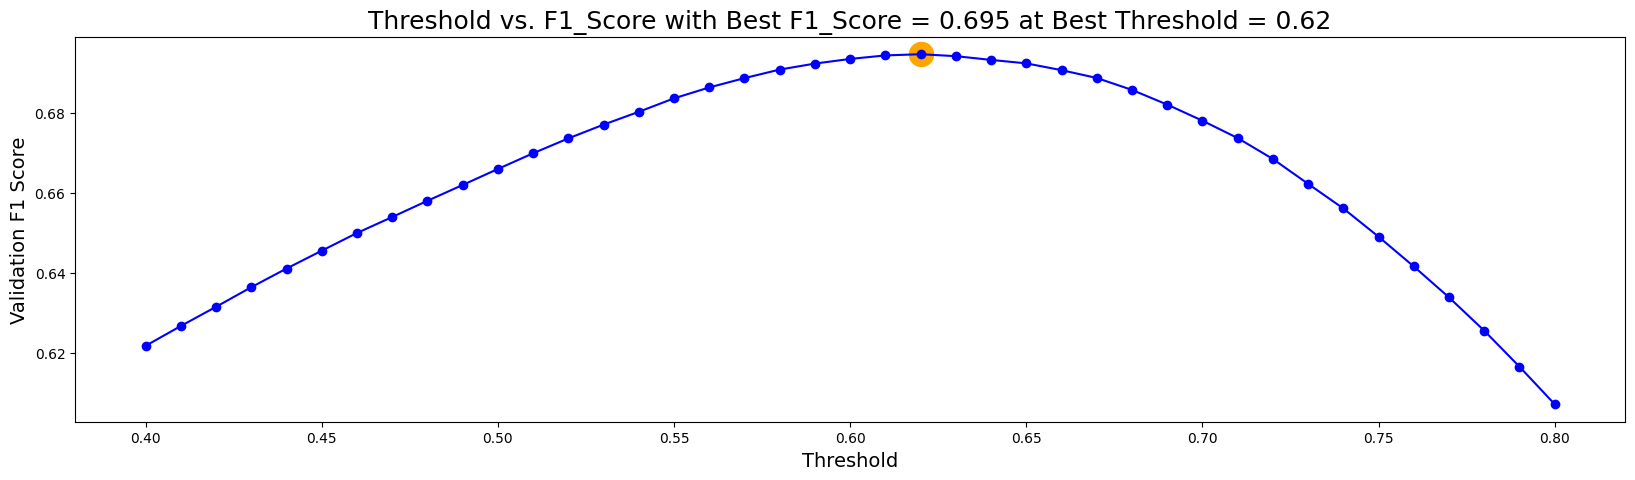

In [6]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], best_score, color='orange', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()